**Ground Gravity Data Layer**

1. Installing Required Libraries

In [ ]:
!pip install rasterio scikit-image matplotlib numpy scipy scikit-learn

2. Uploading Required Files for Processing

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Ground_Gravity.tif to Ground_Gravity.tif


3. Gravity Raster Data Preprocessing

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, sobel, uniform_filter
from skimage import filters
from sklearn.feature_extraction.image import extract_patches_2d

filename = list(uploaded.keys())[0]
with rasterio.open(filename) as src:
    gravity = src.read(1).astype(np.float32)
    profile = src.profile
    nodata = src.nodata
    transform = src.transform
    crs = src.crs
    gravity[gravity == nodata] = np.nan


<ipython-input-54-578aa9a86401>:10: RuntimeWarning: overflow encountered in cast
  gravity = src.read(1).astype(np.float32)
<ipython-input-54-578aa9a86401>:15: RuntimeWarning: overflow encountered in cast
  gravity[gravity == nodata] = np.nan


4. Plotting the Output

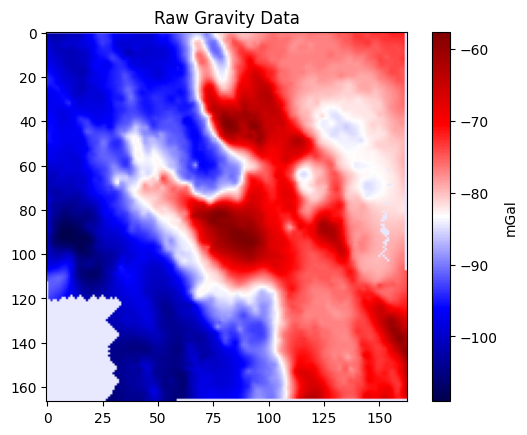

In [ ]:
gravity = np.where(np.isnan(gravity), np.nanmean(gravity), gravity)

plt.imshow(gravity, cmap='seismic')
plt.colorbar(label='mGal')
plt.title('Raw Gravity Data')
plt.show()

5. Filtering the Data

In [ ]:
gravity_smooth = gaussian_filter(gravity, sigma=1.5)

6. Calculation for First Vertical Derivative, Horizontal Gradient Magnitude, Tilt Derivatives, Analytic Signal, Second Vertical Derivative

In [ ]:
gx = sobel(gravity_smooth, axis=1)
gy = sobel(gravity_smooth, axis=0)
fvd = sobel(gravity_smooth, axis=0)
hgm = np.sqrt(gx**2 + gy**2)
tdr = np.arctan2(fvd, hgm + 1e-6)
asignal = np.sqrt(gx**2 + gy**2 + fvd**2)
svd = sobel(fvd, axis=0)


regional = uniform_filter(gravity_smooth, size=50)
residual = gravity_smooth - regional
edges = filters.sobel(residual)



7. Normalise the Data Layers

In [ ]:
def normalize(layer):
    layer = np.where(np.isnan(layer), np.nanmean(layer), layer)
    return (layer - np.min(layer)) / (np.max(layer) - np.min(layer))


In [ ]:
def normalize(layer):
    return (layer - np.nanmin(layer)) / (np.nanmax(layer) - np.nanmin(layer))

layers = {
    'gravity': normalize(gravity_smooth),
    'fvd': normalize(fvd),
    'hgm': normalize(hgm),
    'tdr': normalize(tdr),
    'as': normalize(asignal),
    'residual': normalize(residual),
    'edges': normalize(edges),
    'svd': normalize(svd),
}

 8. Checking how many NaN (Not a Number) values are present in each layer

In [ ]:
for name, layer in layers.items():
    print(f"{name} NaNs:", np.isnan(layer).sum())


gravity NaNs: 0
fvd NaNs: 0
hgm NaNs: 0
tdr NaNs: 0
as NaNs: 0
residual NaNs: 0
edges NaNs: 0
svd NaNs: 0


9. Plotting the Outputs

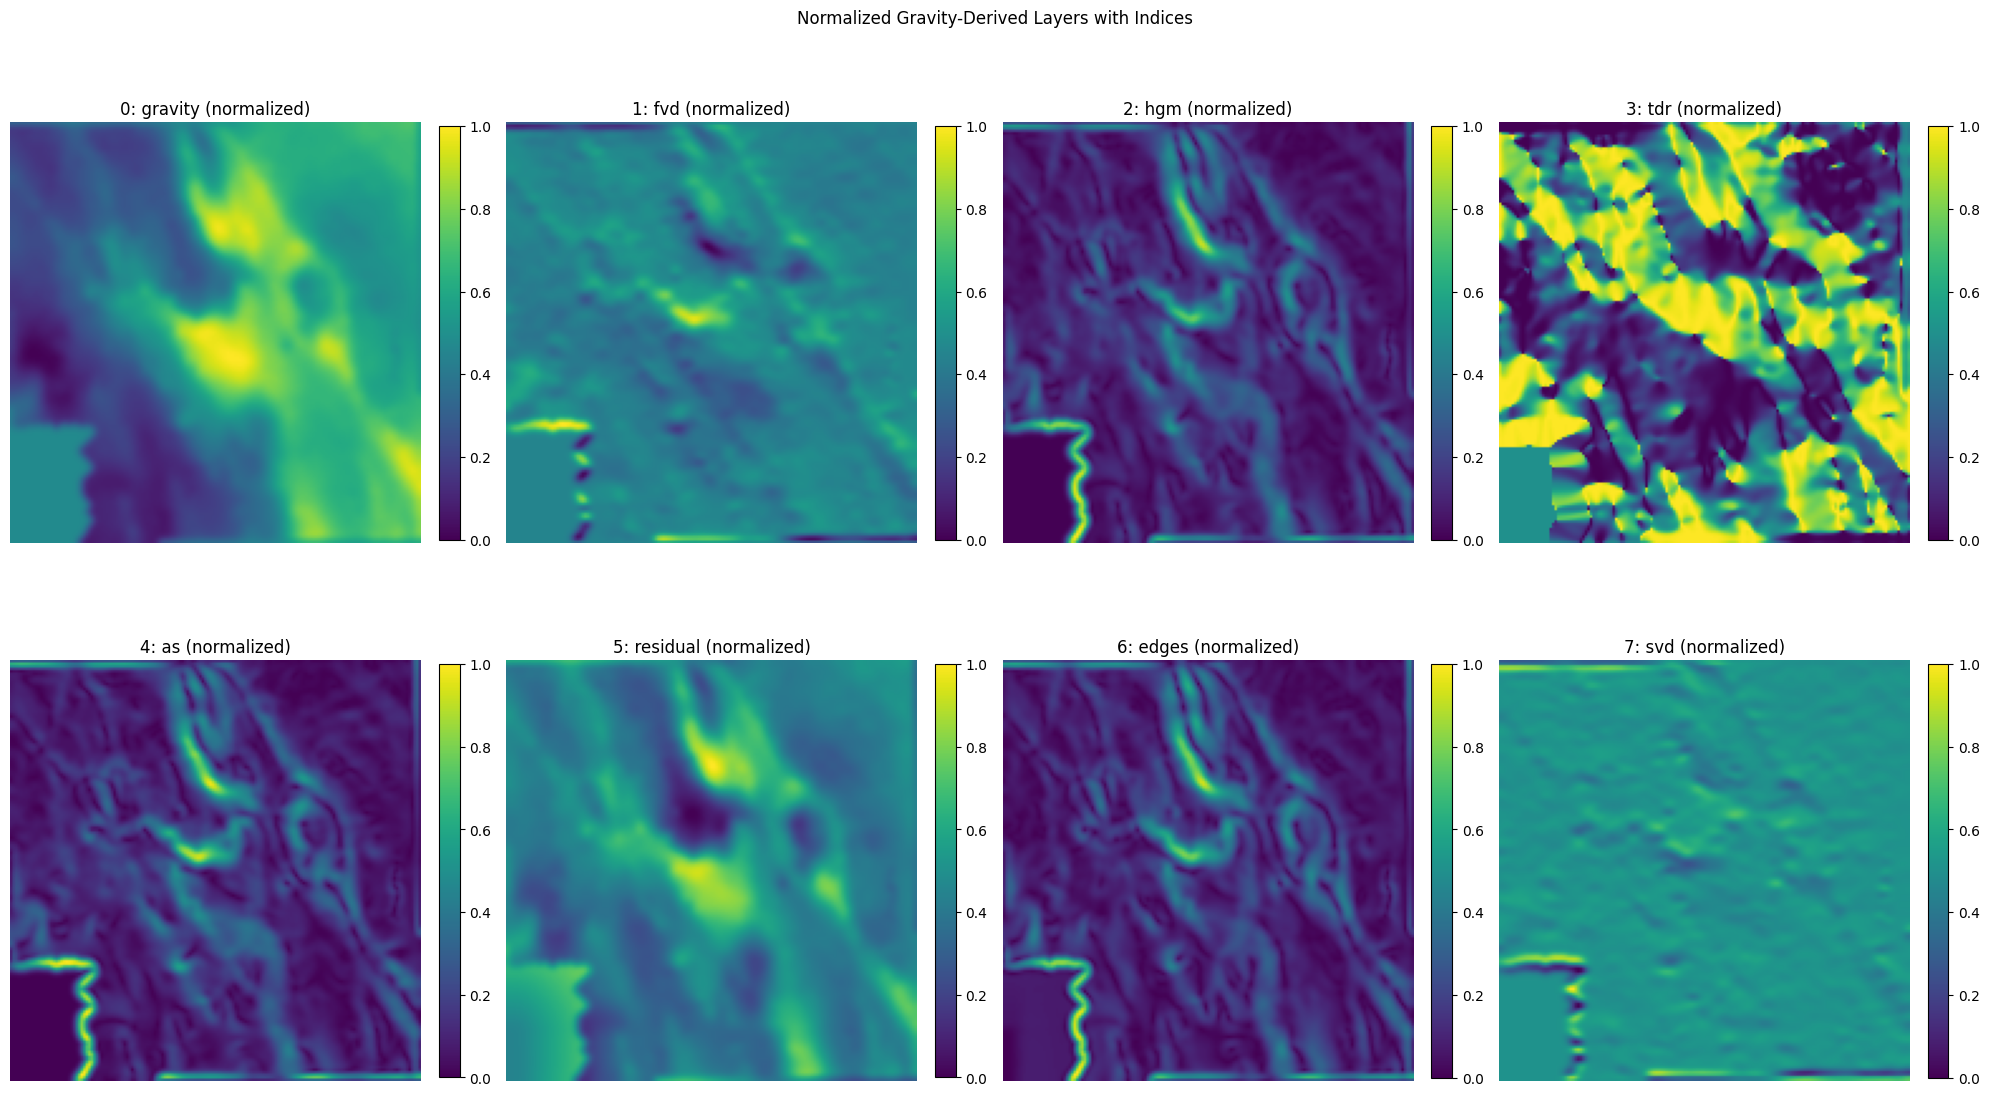

In [ ]:
plt.figure(figsize=(20, 12))
for i, (name, layer) in enumerate(layers.items()):
    ax = plt.subplot(2, 4, i + 1)
    im = ax.imshow(layer, cmap='viridis')
    ax.set_title(f"{i}: {name} (normalized)")
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.suptitle("Normalized Gravity-Derived Layers with Indices")
plt.tight_layout()
plt.show()


10. Extracting the Outputs

In [ ]:
import os
from rasterio.transform import from_origin

output_dir = '/content/normalized_outputs'
os.makedirs(output_dir, exist_ok=True)
selected_layers = ['fvd', 'svd', 'hgm', 'tdr', 'as']

for name in selected_layers:
    out_path = os.path.join(output_dir, f"{name}.tif")
    with rasterio.open(
        out_path, 'w',
        driver='GTiff',
        height=layers[name].shape[0],
        width=layers[name].shape[1],
        count=1,
        dtype='float32',
        crs=crs,
        transform=transform
    ) as dst:
        dst.write(layers[name], 1)

print("Exported normalized layers (GeoTIFFs) to:", output_dir)

Exported normalized layers (GeoTIFFs) to: /content/normalized_outputs
